# Проект: A/B-тест сравнения двух групп по кнверсии и среднему чеку в интернет - магазине.

# Описание проекта

**Я— аналитик крупного интернет-магазина. Вместе с отделом маркетинга мц подготовили список гипотез для увеличения выручки.**

**Цель исследования**

* Приоритизировать гипотезы,
* Запуститить A/B-тест
* Проанализировать результаты

## Изучение данных 

### Импортируем библиотеки, выводим таблицы и знакомимся с данными

In [1]:
import pandas as pd
import scipy.stats as stats
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt 
from pandas.plotting import register_matplotlib_converters
import seaborn as sns 
import math
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_colwidth', 1000) #вывод всех символов в записях
register_matplotlib_converters()

In [2]:
orders = pd.read_csv('/data/orders.csv')
visitors = pd.read_csv('/data/visitors.csv')
hypothesis = pd.read_csv('/data/hypothesis.csv')

**Выводим первые 5 строк таблицы c данными (и так по каждой из трёх)**

**Получаем общую информацию о таблице( и так по каждой из трёх)**

In [3]:
orders.info()
orders.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [4]:
visitors.info()
visitors.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [5]:
hypothesis.info()
hypothesis.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1


### Вывод:

**В нашем распоряжении 3 таблицы:**

**1. `hypothesis`(Данные для первой части) - 5 столбцов, 9  строк записей, 2 типа данных: `int64` и  `object`.**

**Структура**
* `Hypothesis` - краткое описание гипотезы;
* `Reach` - охват пользователей по 10-балльной шкале;
* `Impact` - влияние на пользователей по 10-балльной шкале;
* `Confidence` - уверенность в гипотезе по 10-балльной шкале;
* `Efforts` - затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение `Efforts`, тем дороже проверка гипотезы.

**2. `orders`(Данные для второй части) - 5 столбцов, 1197 строк записей, 2 типа данных: `int64` и `object`.**

**Структура**
* `transactionId` - идентификатор заказа;
* `visitorId` - идентификатор пользователя, совершившего заказ;
* `date` - дата, когда был совершён заказ;
* `revenue` - выручка заказа;
* `group` - группа A/B-теста, в которую попал заказ.

**3. `visitors`(Данные для второй части) - 3 столбца, 62 строки записей, 2 типа данных: `int64` и `object`.**

**Структура**
* `date` - дата;
* `group` - группа A/B-теста;
* `visitors` - количество пользователей в указанную дату в указанной группе A/B-теста.

**В названиях колонок видны нарушения стиля:**
* Необходимо привести к нижнему регистру столбцы таблицы `hypothesis`.

**Так же необходимо изменить тип данных в некоторых столбцах в таблицах `orders` и `visitors`.**

### Предобработка данных

#### Стиль заголовков

**Начнём с прееимнования столбцов всех таблиц и приведём их к нижнему регистру**

**Выведем на экран названия столбцов:**

In [6]:
print(hypothesis.columns)
print(orders.columns)
print(visitors.columns)

Index(['Hypothesis', 'Reach', 'Impact', 'Confidence', 'Efforts'], dtype='object')
Index(['transactionId', 'visitorId', 'date', 'revenue', 'group'], dtype='object')
Index(['date', 'group', 'visitors'], dtype='object')


**Приведем столбцы к нижнему регистру**

In [7]:
hypothesis.columns = hypothesis.columns.str.lower()

**Проверим**

In [8]:
#Таблицы приведены к единому стилю 
print(hypothesis.columns)
print(orders.columns)
print(visitors.columns)

Index(['hypothesis', 'reach', 'impact', 'confidence', 'efforts'], dtype='object')
Index(['transactionId', 'visitorId', 'date', 'revenue', 'group'], dtype='object')
Index(['date', 'group', 'visitors'], dtype='object')


#### Тип данных

**В двух таблицах есть столбцы с датами, которые имею тип `object`, а именно:**
* `orders` - `date`
* `visitors` - `date`

**Для дальнейшей работы необходимо изменить их тип на datetime**

In [9]:
#для таблицы orders
orders['date'] = pd.to_datetime(orders['date'])

In [10]:
orders.info() #проверяем

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1197 non-null   int64         
 1   visitorId      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   int64         
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


In [11]:
#для таблицы visitors
visitors['date'] = pd.to_datetime(visitors['date'])

In [12]:
visitors.info() #проверяем

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


**Тип данных в таблицах изменён**

#### Дубликаты

**Проверим таблицы на отстутствие дубликатов**

In [13]:
hypothesis.duplicated().sum()

0

In [14]:
orders.duplicated().sum()

0

In [15]:
visitors.duplicated().sum()

0

**Дубликаты отсутствуют**

#### Пропуски

**Посмотрим пропуски**

In [16]:
hypothesis.isna().sum()

hypothesis    0
reach         0
impact        0
confidence    0
efforts       0
dtype: int64

In [17]:
orders.isna().sum()

transactionId    0
visitorId        0
date             0
revenue          0
group            0
dtype: int64

In [18]:
visitors.isna().sum()

date        0
group       0
visitors    0
dtype: int64

**Пропуски отсутствуют**

**Посмотрим, наличие пользователей, которые попали в 2 теста одновременно**

In [19]:
two_groups_users = orders.groupby('visitorId').agg({'group':'nunique'})
two_groups_users = two_groups_users.query('group > 1')
two_groups_users['group'].count()

58

**Таким образом мы наблюдаем 58 пользователей, которые находятся в группах А и В нашего теста одновременно.**

### Вывод:

**Провели предобработку и подготовили наши данные к дальнейшему исследованию.**

**А именно:**
* Исправили заголовки столбцов и привели их к "хорошему" стилю
* Изменили тип данных в таблицах с датами
* Проверили таблицы на наличие дубликатов (дубликатов нет)
* Проверили таблицы на наличие пропусков (пропусков нет

## Часть 1. Приоритизация гипотез.

**Задачи:**
* Применить фреймворк ICE для приоритизации гипотез. Отсортировать их по убыванию приоритета.
* Применить фреймворк RICE для приоритизации гипотез. Отсортировать их по убыванию приоритета.
* Указать, как изменилась приоритизация гипотез при применении RICE вместо ICE. Объяснить, почему так произошло.

### Применим фреймворк ICE для приоритизации гипотез. Отсортируем их по убыванию приоритета.

In [20]:
hypothesis

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


**Посчитаем `ICE` для гипотез. Добавим полученные значения `ICE` к существующей таблице. Новый столбец назовём `ICE`**

In [21]:
hypothesis['ICE'] = (hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']

In [22]:
ice = hypothesis[['hypothesis','ICE']].sort_values(by='ICE', ascending=False).round(2)

In [23]:
ice

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


### Применим фреймворк RICE для приоритизации гипотез. Отсортируем их по убыванию приоритета.

In [24]:
hypothesis.round(0)

,hypothesis,reach,impact,confidence,efforts,ICE
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.0
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.0
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.0


**Посчитаем `RICE` для гипотез. Добавим полученные значения `RICE` к существующей таблице. Новый столбец назовём `RICE`**

In [25]:
hypothesis['RICE'] = (hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']

In [26]:
hrice = hypothesis[['hypothesis','RICE']].sort_values(by='RICE', ascending=False)
hrice

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


**Объединим результаты в единой таблице для наглядности**

In [27]:
unification = ice.merge(hrice, on = 'hypothesis') # объединяем

cm = sns.light_palette("green", as_cmap=True) #выделяем цветом
unification.style.background_gradient(cmap=cm)

,hypothesis,ICE,RICE
0,"Запустить акцию, дающую скидку на товар в день рождения",16.200000,16.200000
1,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.330000,40.000000
2,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200000,112.000000
3,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000000,40.000000
4,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000000,56.000000
5,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000000,4.000000
6,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.330000,4.000000
7,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.120000,9.000000
8,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000000,3.000000


### Как изменилась приоритизация гипотез при применении RICE вместо ICE. Объяснить, почему так произошло.

**Мы применили один из самых популярных способов приоритизации задач `ICE`(«влияние, уверенность, усилия / простота») и его модификатор `RICE`(«охват»).**

**Какую приоритезацию гипотез показал `ICE`:**
* 8	Запустить акцию, дающую скидку на товар в день рождения	16.20
* 0	Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей	13.33
* 7	Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок	11.20
* 6	Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию	8.00
* 2	Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа	7.00

**Какую приоритезацию гипотез показал `RICE`:**

* 7	Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок	112.0
* 2	Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа	56.0
* 0	Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей	40.0
* 6	Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию	40.0
* 8	Запустить акцию, дающую скидку на товар в день рождения	16.2

**Исходя из вышеизложенного, рекомендуется в первую очередь протестировать гипотезы:**

* Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
* Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа  

## Часть 2. Анализ A/B-теста

**Задача**

* Проанализировать A/B-тест:

### Построим график кумулятивной выручки по группам. Сделаем выводы и предположения.

**1) Создадим датафрейм `datesGroups` с уникальными парами значений `date` и `group`, таблицы `orders`. Избавимся от дубликатов методом `drop_duplicates()`.**

**Выведем таблицы `orders` и `visitors`**

In [28]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [29]:
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


**Cоздаем массив уникальных пар значений дат и групп теста**

In [30]:
datesGroups = orders[['date','group']].drop_duplicates() 

**2) Объявим переменную `ordersAggregated`, содержащую:**
* дату;
* группу A/B-теста;
* число уникальных заказов в группе теста по указанную дату включительно;
* число уникальных пользователей, совершивших хотя бы 1 заказ в группе теста по указанную дату включительно;
* суммарную выручку заказов в группе теста по указанную дату включительно.

In [31]:
ordersAggregated = datesGroups.apply(
    lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg({
        'date' : 'max',
        'group' : 'max',
        'transactionId' : pd.Series.nunique,
        'visitorId' : pd.Series.nunique,
        'revenue' : 'sum'}), axis=1).sort_values(by=['date','group']) 

**3) Объявим переменную `visitorsAggregated`, содержащую:**
* дату;
* группу A/B-теста;
* количество уникальных посетителей в группе теста по указанную дату включительно.

In [32]:
visitorsAggregated = datesGroups.apply(
    lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({
        'date' : 'max', 
        'group' : 'max', 
        'visitors' : 'sum'}), axis=1).sort_values(by=['date','group']) 

**`ordersAggregated` и `visitorsAggregated` отсортировали по столбцам `date`, `group`**

**4) Определим переменную `cumulativeData`, объединив `ordersAggregated` и `visitorsAggregated` по колонкам `date`, `group` методом merge()**

In [33]:
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])

**5) Присвоим столбцам `cumulativeData` названия [`date`, `group`, `orders`, `buyers`, `revenue`, `visitors`]**

In [34]:
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

**Взглянем на новую таблицу**

In [35]:
cumulativeData.head(10)

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845
5,2019-08-03,B,61,59,380996,1803
6,2019-08-04,A,84,77,425699,2562
7,2019-08-04,B,78,75,489567,2573
8,2019-08-05,A,109,100,549917,3318
9,2019-08-05,B,101,98,581995,3280


**Найдём минималную и максимальную дату**

In [36]:
cumulativeData['date'].min()

Timestamp('2019-08-01 00:00:00')

In [37]:
cumulativeData['date'].max()

Timestamp('2019-08-31 00:00:00')

**Все нужные кумулятивные данные собраны. Приступаем к построению графиков.**

**Объявим переменные `cumulativeRevenueA` и `cumulativeRevenueB`, в которых сохраним данные о датах, выручке и числе заказов в группах A и B.**

In [38]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А

cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

In [39]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B

cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

**Строим график выручки группы А и В**

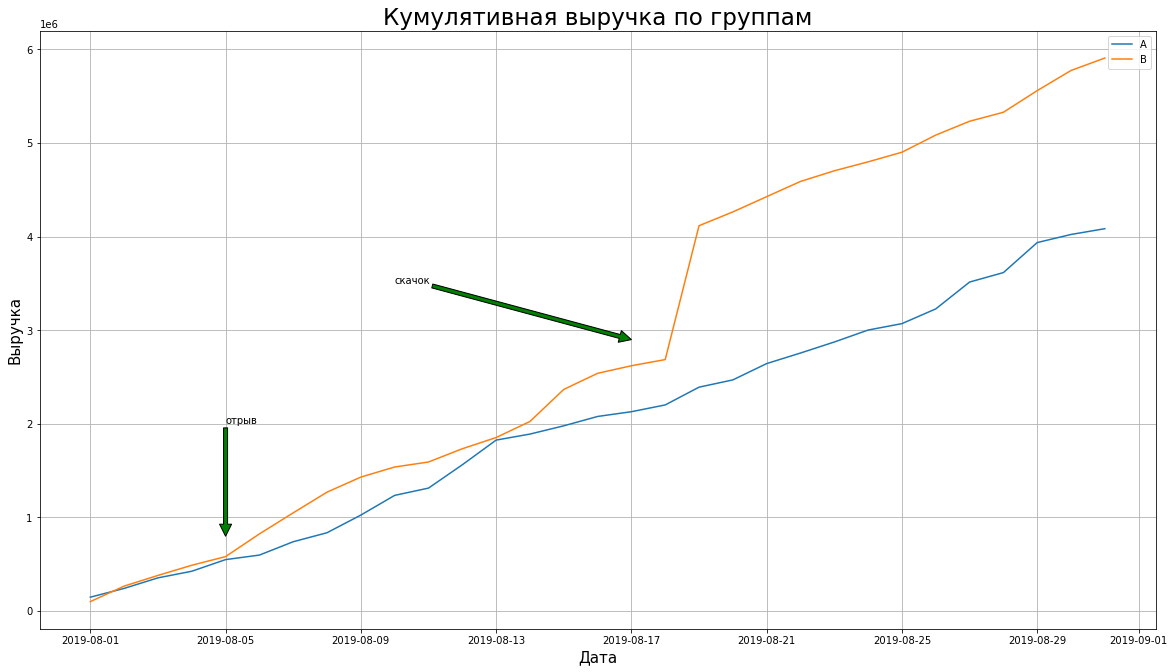

In [40]:
plt.figure(figsize = (20,11))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.title('Кумулятивная выручка по группам', size = 23)
plt.xlabel('Дата', size = 15)
plt.ylabel('Выручка', size = 15)
plt.grid()
plt.annotate('скачок', xy=('2019-08-17', 2900000), xytext=('2019-08-10', 3500000),
            arrowprops=dict(facecolor='g'))
plt.annotate('отрыв', xy=('2019-08-05', 800000), xytext=('2019-08-05', 2000000),
            arrowprops=dict(facecolor='g')) 
plt.legend()
plt.show()

**Примерно в середине теста сегмент В вырвался вперед и продолжил лидировать весь остаток теста. Есть предположение, что есть аномально большие заказы, которые влияют на результаты, а так же их количество**

### Построим график кумулятивного среднего чека по группам. Сделаем выводы и предположения.

**Строим график среднего чека группы А и В**

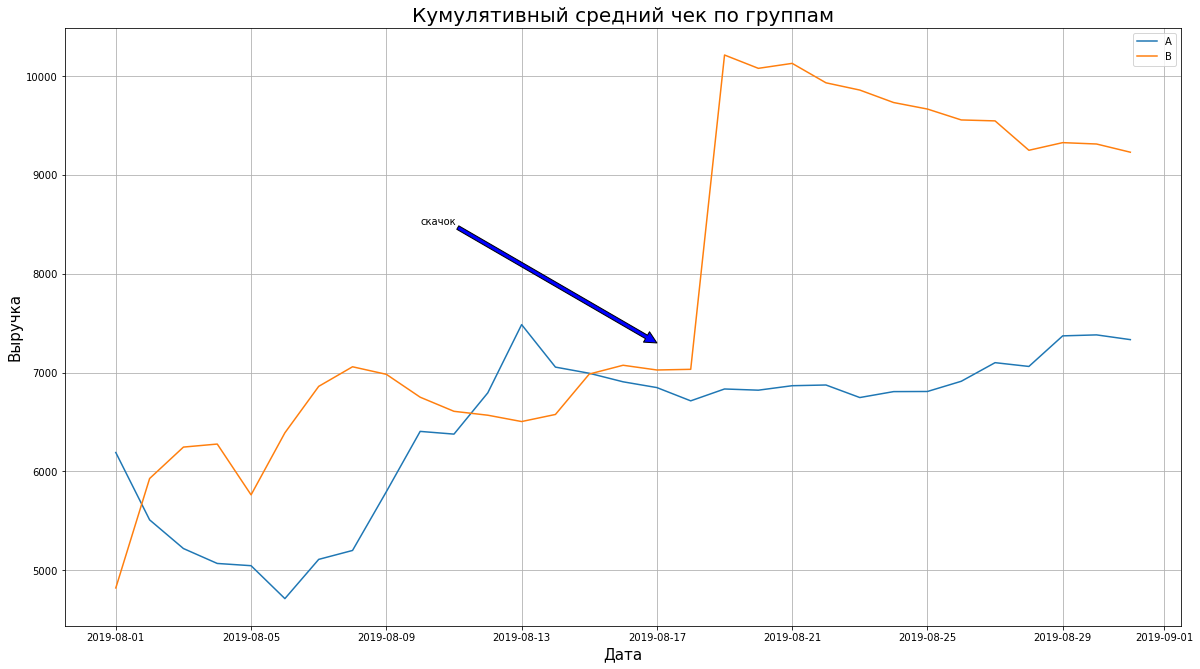

In [41]:
plt.figure(figsize = (20,11))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.title('Кумулятивный средний чек по группам', size = 20)
plt.xlabel('Дата', size = 15)
plt.ylabel('Выручка', size = 15)
plt.annotate('скачок', xy=('2019-08-17', 7300), xytext=('2019-08-10', 8500),
            arrowprops=dict(facecolor='b'))
plt.grid()
plt.legend()
plt.show()

**Наблюдаем колебания обоих сегментов, но сегмент А не так сильно относительно сегмента В. Выделяется сильный скачёк в середине теста у сегмента В. Нужно провести анализ выбросов, которые возможно сильно искажают результат.**

### Построим график относительного изменения кумулятивного среднего чека группы B к группе A. Сделаем выводы и предположения.

**Объединим таблицы `cumulativeRevenueA` и `cumulativeRevenueB` методом merge() так, чтобы она содержала столбцы: [`date`, `revenueA`, `revenueB`, `ordersA`, `ordersB`]. Сохраним в переменной `mergedCumulativeRevenue`.**

In [42]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(
    cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

**Cтроим отношение средних чеков**

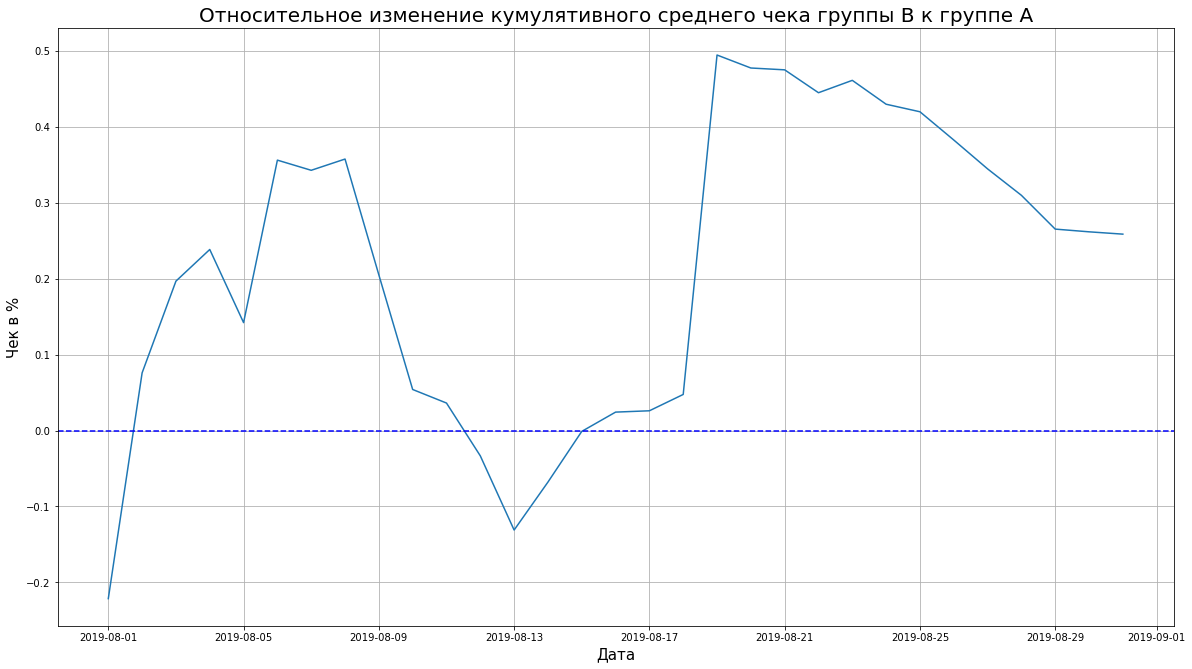

In [43]:
plt.figure(figsize = (20,11))
plt.plot(mergedCumulativeRevenue['date'], 
         (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

plt.title('Относительное изменение кумулятивного среднего чека группы B к группе A', size = 20)
plt.xlabel('Дата', size = 15)
plt.ylabel('Чек в %', size = 15)
# добавляем ось X
plt.axhline(y=0, color='blue', linestyle='--') 
plt.grid()
plt.show()

**Результаты теста резко менялись в несколько дат. Есть предположение, что именно в эти даты были сделаны аномально большие заказы.**

### Построим график кумулятивной конверсии по группам. Сделаем выводы и предположения.

**Добавьте в переменную `cumulativeData` столбец `conversion` c отношением числа заказов к количеству пользователей в указанной группе в указанный день и посчитаем кумулятивную конверсию**

In [44]:
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

**Отделяем данные по группе A**

In [45]:
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

**Отделяем данные по группе В**

In [46]:
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

**Строим график**

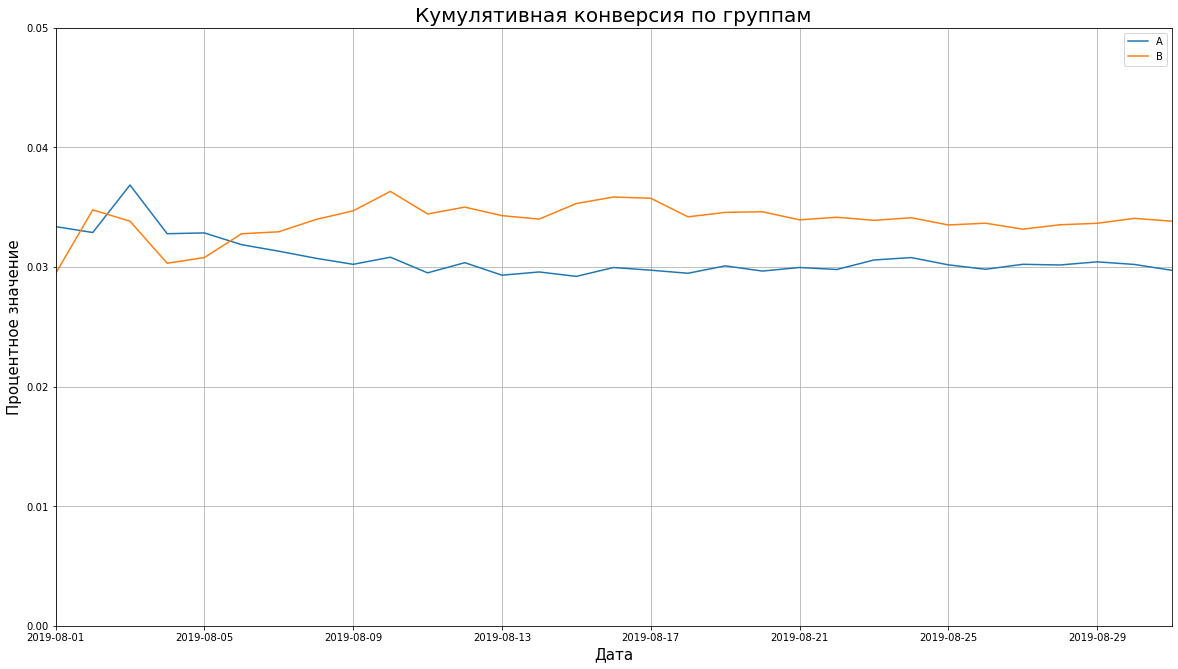

In [47]:
plt.figure(figsize = (20,11))
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.title('Кумулятивная конверсия по группам', size = 20)
plt.xlabel('Дата', size = 15)
plt.ylabel('Процентное значение', size = 15)
plt.legend()
plt.grid()
# задаем масштаб осей
plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 8, 31), 0, 0.05])
plt.show()

**В начале теста групп А имела большую конверсию, но постепенно группа В выровнялась и зафиксировалась около одного значения выше Групы А. Абсолютное значение колебания в начале и в конце теста примерно от 3% до 3,5%**

### Построим график относительного изменения кумулятивной конверсии группы B к группе A. Сделаем выводы и предположения.

**Объединим таблицы `cumulativeDataA` и `cumulativeDataB` так, чтобы она содержала столбцы: [`date`, `conversionA`, `conversionB`]. Сохраним в переменной `mergedCumulativeConversions`.**

In [48]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], 
       left_on='date', right_on='date', how='left', suffixes=['A', 'B']) 

**Строим график**

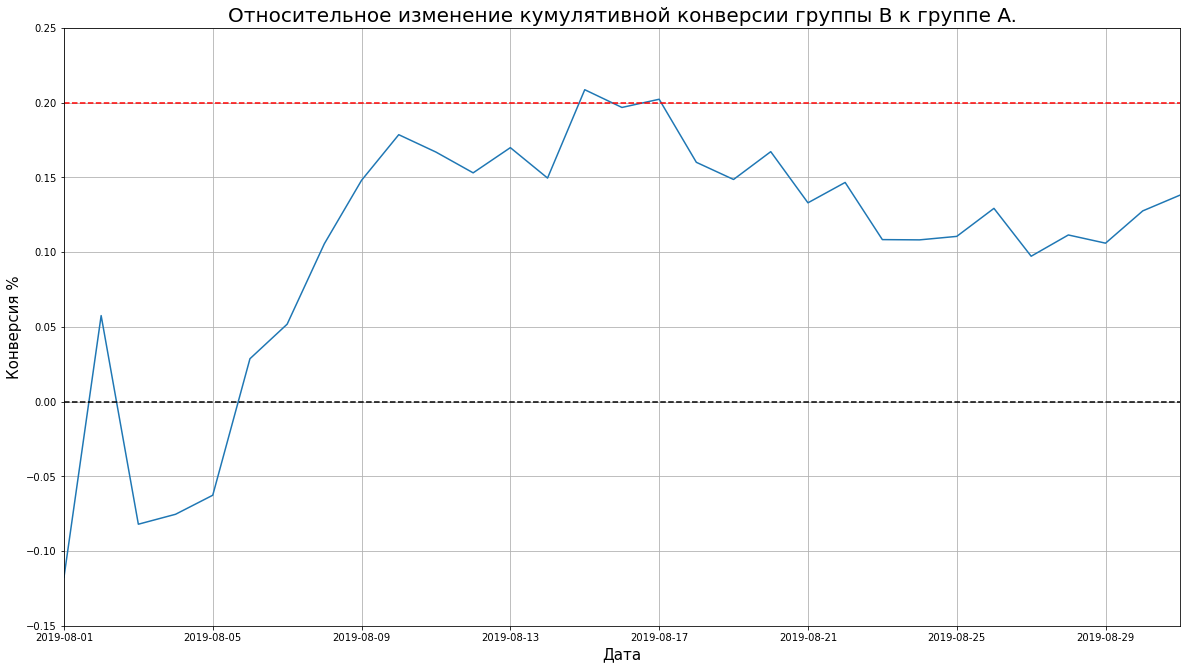

In [49]:
plt.figure(figsize = (20,11))
plt.plot(mergedCumulativeConversions['date'], 
         mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, 
         label="Относительный прирост конверсии группы B относительно группы A")
#plt.legend()
plt.title('Относительное изменение кумулятивной конверсии группы B к группе A.', size = 20)
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.2, color='red', linestyle='--')
plt.axis(['2019-08-01', '2019-08-31', -0.15, 0.25])
plt.xlabel('Дата', size = 15)
plt.ylabel('Конверсия %', size = 15)
plt.grid()
plt.show()

**С самого начала группа В лидирует в конверсии, но достигнув отметки 20% стала немного регрессировать и зафиксировалась в отметке примерно 18% относительно группы А.**

**Так, как наблюдались аномально большие заказы, то их необходимо проанализировать. Они могут сильно искажать результаты A/B-теста**

### Построим точечный график количества заказов по пользователям. Сделаем выводы и предположения.

**Изучим данные о заказах. Найдём число заказов по пользователям - создадим  датафрейм `ordersByUsers` c двумя столбцами: `userId` и `orders`.**

In [50]:
ordersByUsers  = orders.drop(['group', 'revenue', 'date'], 
                             axis=1).groupby('visitorId', as_index=False).agg({'transactionId': pd.Series.nunique})
ordersByUsers.columns = ['userId', 'orders']

**Выводим новый датафрейм с числом заказов по пользователям**

In [51]:
ordersByUsers.sort_values(by='orders', ascending=False).head(10)

,userId,orders
1023,4256040402,11
591,2458001652,11
569,2378935119,9
487,2038680547,8
44,199603092,5
744,3062433592,5
55,237748145,5
917,3803269165,5
299,1230306981,5
897,3717692402,5


**Взглянем на гистограмму распределения числа заказов**

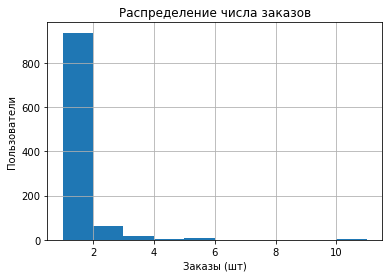

In [52]:
plt.hist(ordersByUsers['orders'])
plt.grid()
plt.title('Распределение числа заказов')
plt.xlabel('Заказы (шт)')
plt.ylabel('Пользователи')
plt.show()

**На гистограмме видно, что большинство пользователей совершили всего один заказ. Неболшая доля пользователей совершили три и более заказов. Посмотим на диаграмме рассеивания**

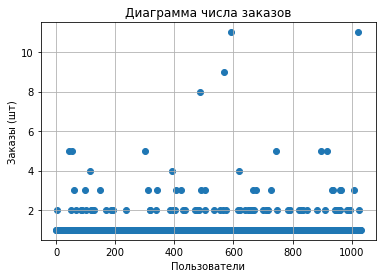

In [53]:
x_values = pd.Series(range(0, len(ordersByUsers))) # числа от 0 до количества наблюдений в ordersByUsers
plt.scatter(x_values, ordersByUsers['orders'])
plt.grid()
plt.title('Диаграмма числа заказов')
plt.xlabel('Пользователи')
plt.ylabel('Заказы (шт)')
plt.show()

**Наблюдаем, что пользователей, которые заказали более двух раз немного. Предположительно они могут быть аномальными**

### Посчитаем 95-й и 99-й перцентили количества заказов на пользователя. Выберем границу для определения аномальных пользователей.

In [54]:
np.percentile(ordersByUsers['orders'], [95, 99])

array([2., 4.])

**Не более 5% совершили не больше 2-х заказов и не более 1% больше 4-х**

### Построим точечный график стоимостей заказов. Сделаем выводы и предположения.

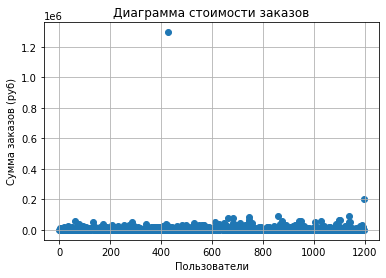

In [55]:
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])
plt.title('Диаграмма стоимости заказов')
plt.grid()
plt.xlabel('Пользователи')
plt.ylabel('Сумма заказов (руб)')
plt.show()

**Наблюдаем 2 аномальных выброса в отметках 200000 и более 12000000. Заказ более миллиона выглядит вполне аномально.**

### Посчитаем 95-й и 99-й перцентили стоимости заказов. Выберем границу для определения аномальных заказов.

In [56]:
np.percentile(orders['revenue'], [95, 99])

array([28000. , 58233.2])

**5% заказов на сумму 28000 и у 1% на сумму более 58233 рублей**

### Посчитаем статистическую значимость различий в конверсии между группами по «сырым» данным. Сделаем выводы и предположения.

**Составим нулевую и альтернативную гипотезы.**

**H₀(нулевая гипотеза) всегда формулируется так, что иcпользовать знак равенства(=).**

 - H₀ - Конверсия в группе A равна конверсии в группе B
 - H₁ - Конверсия в группе A не равна конверсии в группе B

* H₀: данные в выборках взяты из одной и той же генеральной совокупности
* H₁: данные в выборках взяты из разных генеральных совокупностей.

**Пошагово проанализируем A/B-тест**

In [57]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

In [58]:
visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)

In [59]:
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

In [60]:
visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

In [61]:
visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)

In [62]:
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

In [63]:
ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)

In [64]:
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

In [65]:
ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

In [66]:
ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)

In [67]:
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

In [68]:
ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

In [69]:
data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

In [70]:
data.head(5)

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


**Подготовили данные для дальнейшего анализа. Создали новый датафрейм `data` со структурой:**
* `date` — дата;
* `ordersPerDateA` — количество заказов в выбранную дату в группе A;
* `revenuePerDateA` — суммарная выручка в выбранную дату в группе A;
* `ordersPerDateB` — количество заказов в выбранную дату в группе B;
* `revenuePerDateB` — суммарная выручка в выбранную дату в группе B;
* `ordersCummulativeA` — суммарное число заказов до выбранной даты включительно в группе A;
* `revenueCummulativeA` — суммарная выручка до выбранной даты включительно в группе A;
* `ordersCummulativeB` — суммарное количество заказов до выбранной даты включительно в группе B;
* `revenueCummulativeB` — суммарная выручка до выбранной даты включительно в группе B;
* `visitorsPerDateA` — количество пользователей в выбранную дату в группе A;
* `visitorsPerDateB` — количество пользователей в выбранную дату в группе B;
* `visitorsCummulativeA` — количество пользователей до выбранной даты включительно в группе A;
* `visitorsCummulativeB` — количество пользователей до выбранной даты включительно в группе B.

**Посчитаем статистическую значимость различия в конверсии между группами.**

**Создадим переменные `ordersByUsersA` и `ordersByUsersB` со столбцами [`userId`, `orders`] для пользователей, которые заказывали хотя бы 1 раз и  укажем число совершённых заказов.**

In [71]:
#Сгруппируем данные заказов группы А по идентификатору пользователя и найдём уникальные заказы
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)

In [72]:
#Переименуем столбцы
ordersByUsersA.columns = ['userId', 'orders']

**То же самое делаем для группы В**

In [73]:
ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)

In [74]:
ordersByUsersB.columns = ['userId', 'orders'] 

**Объявим переменные `sampleA` и `sampleB`, в которых пользователям с заказами будет соответствовать число заказов пользователя. А пользователям без заказов будут соответствовать нули.**

In [75]:
sampleA = pd.concat([ordersByUsersA['orders'],
                     pd.Series(0, index=np.arange(data['visitorsPerDateA']
                                                  .sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

In [76]:
sampleB = pd.concat([ordersByUsersB['orders'],
                     pd.Series(0, index=np.arange(data['visitorsPerDateB']
                                                  .sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)

**Посчитаем статистическую значимость различия конверсии.**

* Применим тест Манна-Уитни.
* Выведем p-value для сравнения конверсии между группами. 
* Округлим p-value до 5 знаков после запятой.
* Вычислим и выведите относительное различие в конверсии между группами. 
* Округлим до 3 знаков после запятой.

In [77]:
print("{0:.5f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

0.00840


In [78]:
print("{0:.3f}".format((data['ordersPerDateB']
                        .sum()/data['visitorsPerDateB'].sum())/(data['ordersPerDateA']
                                                                .sum()/data['visitorsPerDateA'].sum())-1)) 

0.138


**P-value меньше 0.05, поэтому нулевую гипотезу отвергаем. Анализ "сырых" данных сообщает, что в конверсии между группами есть статистически значимые различия. Отдельный прирост конверсии группы В к конверсии группы А равен 13.8% (нулевая гипотеза всегда приравнивает, значит Н1 - статистически значимые различий в группах имеются).**

### Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. Сделаем выводы и предположения.

* H₀ - Средний чек A равен среднему чеку группы B
* H₁ - Средний чек A  НЕ равен среднему чеку группы B

**Сравним средние чеки по "сырым" данным**

In [79]:
print('{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], 
                                          orders[orders['group']=='B']['revenue'])[1]))

0.365


In [80]:
print('{0:.3f}'.format(orders[orders['group']=='B']['revenue']
                       .mean()/orders[orders['group']=='A']['revenue'].mean()-1)) 

0.259


**P-value больше 0.05, значит статистических различий в среднем чеке между группами нет. Относительное различие средего чека между группами больше 25%**

### Очистка данных от аномалий

**95 и 99 перцентили средних чеков равны 28000 и 58233 рублям. 95 и 99 перцентили числа заказов на одного пользователя равны 2 и 4 заказам на пользователя.**

**Примем за аномальных пользователей тех, кто совершил 4 заказа и более или или совершил заказ на сумму свыше 28 000 рублей.**

**Сначала определить аномальные заказы, затем пользователей, совершивших их и добавим их в список аномальных.**

In [81]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 2]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > 2]['userId'],
    ],
    axis=0,
)

In [82]:
usersWithExpensiveOrders = orders[orders['revenue'] > 28000]['visitorId']

In [83]:
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)

In [84]:
abnormalUsers.head(5)

1099    148427295
18      199603092
928     204675465
23      237748145
37      249864742
dtype: int64

**Выведем количество аномальных пользователей**

In [85]:
abnormalUsers.shape

(74,)

**Итого получили 74 аномальных пользователей. Для дальнейшего анализа их нужно исключить из теста**

### Посчитаем статистическую значимость различий в конверсии между группами по «очищенным» данным. Сделаем выводы и предположения.

* H₀ - Конверсия в группе A равна конверсии в группе B
* H₁ - Конверсия в группе A не равна конверсии в группе B

**Объявим переменные `sampleAFiltered` и `sampleBFiltered`, в которых сохраним очищенные данные о заказах — не включая аномальных пользователей.**

In [86]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

In [87]:
sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

**Выводим p-value**

In [88]:
print('{0:.5f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))

0.00652


In [89]:
print('{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

0.173


**Статистическая значимость достигнута. Группа В лучше группы А. Отвергаем H₀**

### Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. Сделаем выводы и предположения.

* H₀ - Средний чек A равен среднему чеку группы B
* H₁ - Средний чек A не равен среднему чеку группы B

In [90]:
print(
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'], 
            True, # что бы задать 4ый параметр 
            'two-sided' # для двух-стороннего теста
        )[1]
    )
)

0.738


In [91]:
print(
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
)

-0.020


**После очистки данных от аномалий p-value по среднему чеку не изменился т.е. статистически значимых отличий между группами нет. Относительное различие группы В относительно группы А, после очистки данных упало на  27.9%. Отвергаем нулевую гипотезу**

### Принимаем решение по результатам теста 

* Есть статистически значимое различие по конверсии между группами как по сырым данным, так и после фильтрации аномалий.
* Как по сырым, так и по отфильтрованным данным - нет статистически значимого различия по среднему чеку между группами

**График различия конверсии между группами сообщает, что результаты группы B лучше группы A: имеют тенденцию к росту, либо зафиксировались около среднего значения (в 14%)**

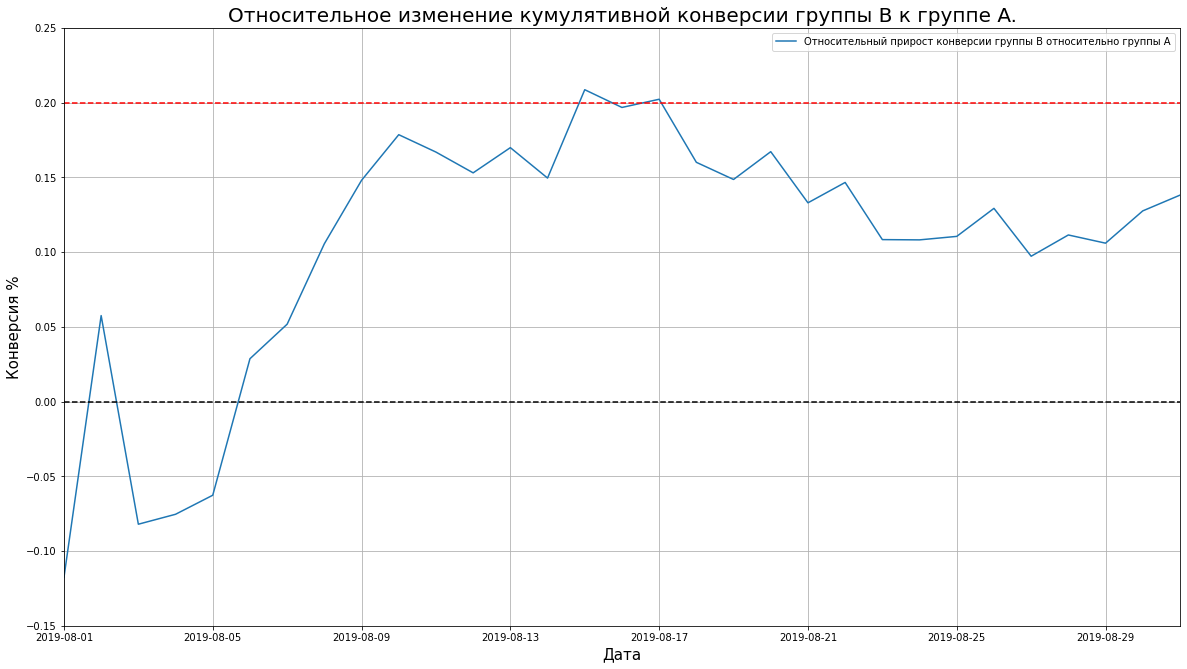

In [92]:
plt.figure(figsize = (20,11))
plt.plot(mergedCumulativeConversions['date'], 
         mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, 
         label="Относительный прирост конверсии группы B относительно группы A")
plt.legend()
plt.title('Относительное изменение кумулятивной конверсии группы B к группе A.', size = 20)
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.2, color='red', linestyle='--')
plt.axis(['2019-08-01', '2019-08-31', -0.15, 0.25])
plt.xlabel('Дата', size = 15)
plt.ylabel('Конверсия %', size = 15)
plt.grid()
plt.show()

**График различия среднего чека колеблется: он-то и позволил нам найти аномалии. Сделать из этого графика определённые выводы нельзя.**

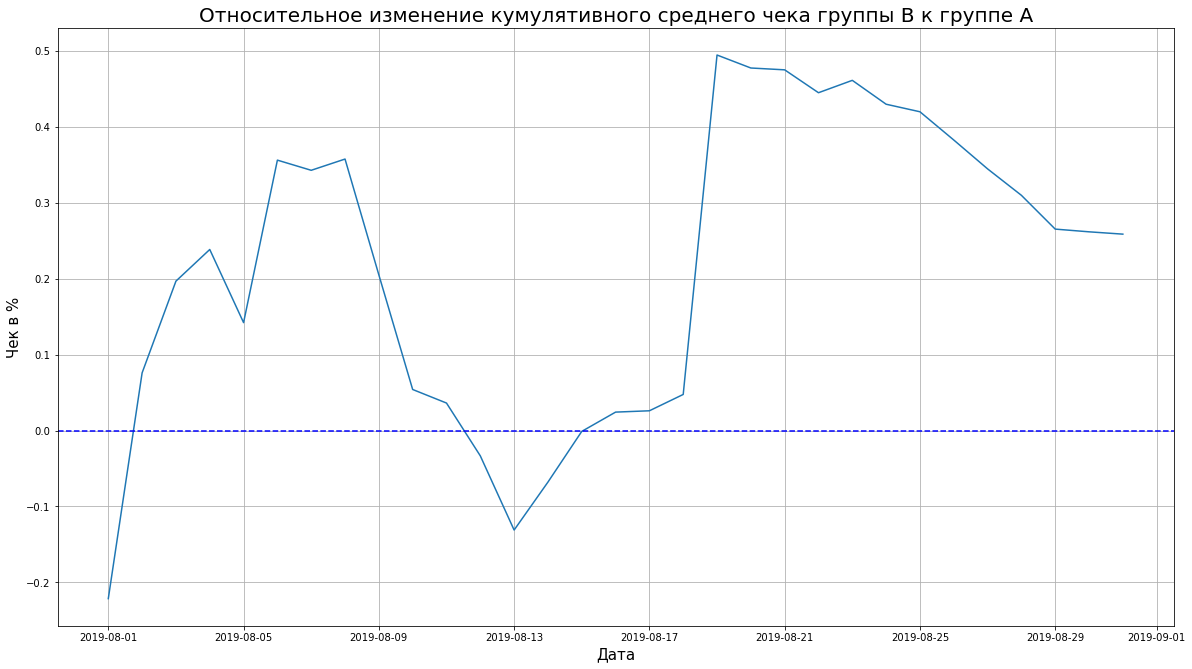

In [93]:
plt.figure(figsize = (20,11))
plt.plot(mergedCumulativeRevenue['date'], 
         (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

plt.title('Относительное изменение кумулятивного среднего чека группы B к группе A', size = 20)
plt.xlabel('Дата', size = 15)
plt.ylabel('Чек в %', size = 15)
# добавляем ось X
plt.axhline(y=0, color='blue', linestyle='--') 
plt.grid()
plt.show()

### Вывод:

**На этапе предобработки подготовили наши данные к дальнейшему исследованию.**

**А именно:**
* Исправили заголовки столбцов и привели их к "хорошему" стилю
* Изменили тип данных в таблицах с датами для удобства работы
* Проверили таблицы на наличие дубликатов (дубликатов нет)
* Проверили таблицы на наличие пропусков (пропусков нет)

**Данные в общем и целом хорошие, но с недочётами, которые быстро исправили для корректной работы**

**На этапе приоритезации гипотез сделали следующее:**
* Применили фреймворк ICE для приоритизации гипотез. 
* Применили фреймворк RICE для приоритизации гипотез.

**В результате выяснили что в приоритете имеют место быть следующие гипотезы, так как охват у них больше:**

* Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
* Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа

**Общий итог:**

* Есть статистически значимое различие по конверсии между группами как по сырым данным, так и после фильтрации аномалий.


* Как по сырым, так и по отфильтрованным данным - нет статистически значимого различия по среднему чеку между группами (раз p-value больше уровня значимости, то никаких отличий между группами нет. Выигрыш группы А в данном случае просто шум, случайность).


* График различия конверсии между группами сообщает, что результаты группы B лучше группы A: имеют тенденцию к росту, либо зафиксировались около среднего значения (в 13%), после удаления аномалий - 17.3%


**По результатам теста видно, что пользователи стали покупать чаще на ту же сумму.**

**Исходя из проведенного теста, его следует остановить и признать успешным, так как значения значения комулятивных метрик стабилизировались. Конверсия выросла, а срений чек не поменялся.**

**По итогу группа В относительно группы А - лучше, так как группа В приносит бизнесу больше денег.**